# Visualization of JEPA masking

This notebook shows the context and target masking strategy in JEPA [1] applied to 3D medical images. Specifically, given an image, M=4 target blocks (set of patches) with random scale and aspect ratio are sampled and 1 context block with random scale is sampled without overlap with target blocks. Context block is supposed to be informative enough to be predictive of target blocks. 

[1] Self-Supervised Learning from Images with a Joint-Embedding Predictive Architecture, Assran et al., CVPR 2023


## Load the OpenBHB dataset

In [4]:
from nidl.datasets.openbhb import OpenBHB

dataset = OpenBHB("/neurospin/signatures/bd261576/openBHB", modality="quasiraw", split="train", target="age")

## Visualize context and target masks

First, let's create a utility function to plot the masks generated by the collate function overlayed on the original image. 

In [2]:
import numpy as np
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

def create_mask_from_patch_indices(indices, patch_size, image_shape=(128, 128, 128)):
    H, W, D = image_shape
    num_patches = (H // patch_size, W // patch_size, D // patch_size)

    # unravel 1D indices to 3D patch grid
    zyx = np.unravel_index(indices, num_patches)  # returns (z, y, x)
    zyx = np.stack(zyx, axis=1)  # shape: (N, 3)

    mask = np.zeros(image_shape, dtype=np.uint8)
    for z, y, x in zyx:
        mask[
            z*patch_size : (z+1)*patch_size,
            y*patch_size : (y+1)*patch_size,
            x*patch_size : (x+1)*patch_size
        ] = 1
    return mask

def display_images_with_masks(images, 
                              encoder_patch_indices, 
                              predictor_patch_indices_list, 
                              patch_size=16, 
                              image_shape=(128, 128, 128)):
    # Set up figure
    n_targets = len(predictor_patch_indices_list)
    fig, axes = plt.subplots(len(images), 1+n_targets, 
                             figsize=((1+n_targets)*4, len(images)*4), 
                             squeeze=False)
    titles = ['Context (Encoder)'] + [f'Target {i+1}' for i in range(n_targets)]

    for i, image in enumerate(images):
        # Reconstruct masks
        encoder_mask = create_mask_from_patch_indices(encoder_patch_indices[i], patch_size, image_shape)
        target_masks = [create_mask_from_patch_indices(p_idx[i], patch_size, image_shape) for p_idx in predictor_patch_indices_list]

        # Convert to Nifti
        img_nifti = nib.Nifti1Image(image.astype(np.float32), affine=np.eye(4))
        encoder_nifti = nib.Nifti1Image(encoder_mask.astype(np.float32), affine=np.eye(4))
        target_niftis = [nib.Nifti1Image(mask.astype(np.float32), affine=np.eye(4)) for mask in target_masks]

        # Display masks using nilearn
        for j, ax in enumerate(axes[i]):
            display = plotting.plot_anat(img_nifti, display_mode='ortho', figure=fig, 
                                        axes=ax, annotate=False, draw_cross=False)
            if j == 0:
                display.add_overlay(encoder_nifti, cmap='Blues', alpha=0.5)
            else:
                display.add_overlay(target_niftis[j-1], cmap='Reds', alpha=0.5)
            if i == 0:
                ax.set_title(titles[j])    
    plt.show()
    return fig


/tmp/ipykernel_2935514/2988800554.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  zyx = np.unravel_index(indices, num_patches)  # returns (z, y, x)


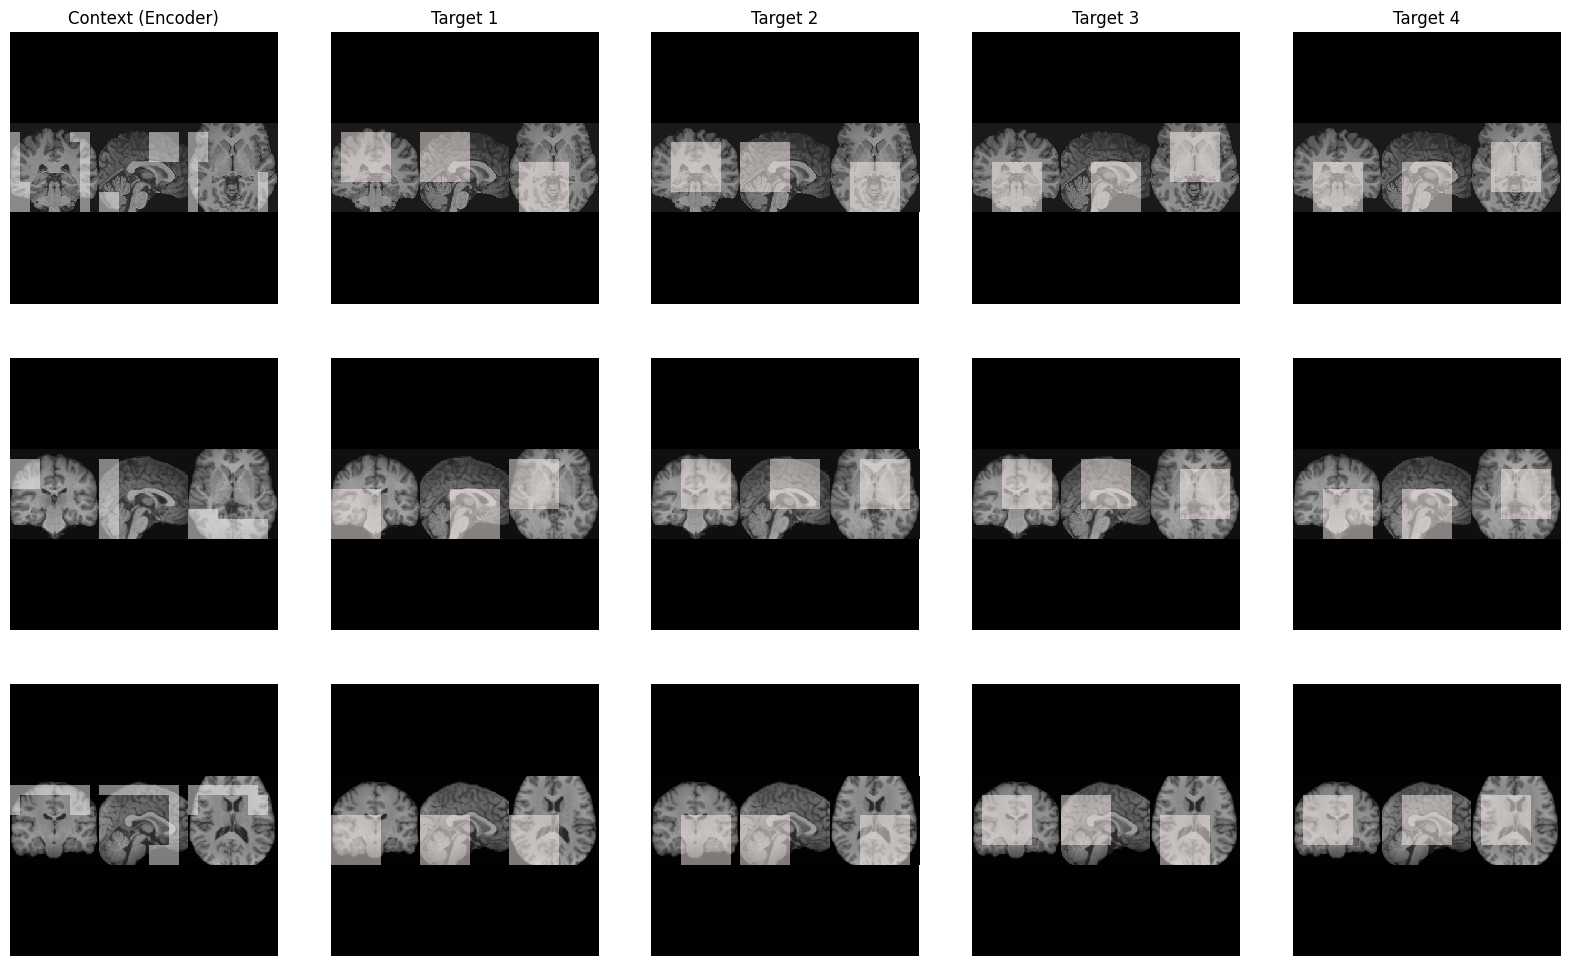

In [8]:
from nidl.data.collate import MaskCollateFunction
from nidl.volume.transforms import CropOrPad

image_size = (144, 144, 144)
collate_fn = MaskCollateFunction(
    input_size=image_size,
    patch_size=16,
    transform=CropOrPad(size=(1,)+image_size)
)

# Get a batch of images
b_size = 3
batch = [dataset[i] for i in range(b_size)]

# Collate the batch + get masks
collated_batch = collate_fn(batch)

# Visualize the masks
fig = display_images_with_masks(
    collated_batch[0][:, 0].numpy(), # select only the first channel
    collated_batch[2][0], # only one context mask
    collated_batch[3], # but several target masks
    patch_size=16,
    image_shape=image_size
)


